# IonQ Continued: Rolling Beta Esitmation

In the previous notebook we set up a method to test the hypothesis that there was a correlation between IonQ publishing papers on arXiv about their research into quantum computing, and the returns on the IONQ ticker. We saw that initial anlaysis did not point to this being the case, but that there are potential robustness checks we could perform to ensure we are accurately getting the values we need to perform the analysis. In this notebook we will perform a similar analysis, but we will estimate our abnormal returns using a rolling regression

## Why Rolling Regression?

A stocks influence by the market is very much an evolving one; it is entirely circumstantial to the position the market is in as well as the position that the company is in. While we can approximate the relationship of a stock to the market ($\beta$) over long time windows, the more dynamic your estimation is the more closely one can understand the precise correlation at a given time. In the previous notebook we regrssed the returns of IONQ against ^GSPC over a four year period, and used the regression residuals to get our abnormal returns metric. How would this change if we made our regression more robust to more accurately capture the dynamics of the assets correlation to the overall market?

## Data

In [1]:
import pandas as pd
import yfinance as yf

stock_data = pd.read_pickle("../data/ionq_price_data.pkl")
arxiv_df = pd.read_pickle("../data/arxiv_pubs.pkl")
market_returns = yf.download("^GSPC", start=stock_data.index[0])['Close'].pct_change().dropna()

/var/folders/z6/_3pyslnx09v4vxgrswzkct1h0000gn/T/ipykernel_74079/2533572555.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_returns = yf.download("^GSPC", start=stock_data.index[0])['Close'].pct_change().dropna()
[*********************100%***********************]  1 of 1 completed


## Analysis

Let's consider a 120 index window for this example:

In [35]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

window = 35

Y = stock_data['Close']['IONQ'].pct_change().dropna()
X = market_returns
X = sm.add_constant(X)

reg = RollingOLS(Y,X,window=window,expanding=True).fit()

alpha = reg.params['const'].fillna(method='bfill')
beta = reg.params['^GSPC'].fillna(method='bfill')

residual = Y - (X['^GSPC']*beta) - alpha
residual = residual[1:]
beta = beta[2:]
alpha = alpha[2:]

/Users/williamfriend/anaconda3/envs/qsig/lib/python3.13/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
/var/folders/z6/_3pyslnx09v4vxgrswzkct1h0000gn/T/ipykernel_74079/3108267697.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  alpha = reg.params['const'].fillna(method='bfill')
/var/folders/z6/_3pyslnx09v4vxgrswzkct1h0000gn/T/ipykernel_74079/3108267697.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  beta = reg.params['^GSPC'].fillna(method='bfill')


We can quickly visualize the regression residual (or the abnormal returns), as well as our regression parameters:

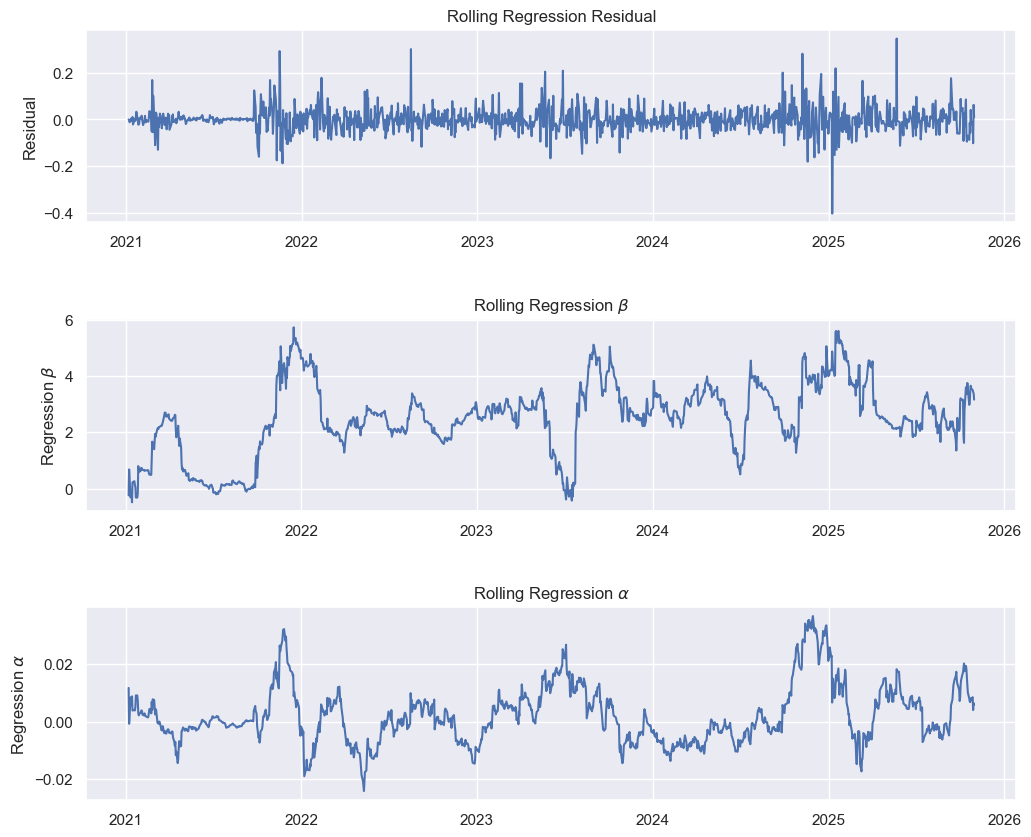

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, ax = plt.subplots(3, 1,figsize=(12,10))
_ = ax[0].plot(residual)
_ = ax[0].set_ylabel("Residual")
_ = ax[0].set_title("Rolling Regression Residual")

_ = ax[1].plot(beta)
_ = ax[1].set_ylabel(r"Regression $\beta$")
_ = ax[1].set_title(r"Rolling Regression $\beta$")

_ = ax[2].plot(alpha)
_ = ax[2].set_ylabel(r"Regression $\alpha$")
_ = ax[2].set_title(r"Rolling Regression $\alpha$")

plt.subplots_adjust(wspace=0.3, hspace=0.5)

In [16]:
import sys
sys.path.append('../')
from src.compute_car import compute_car

import scipy.stats as stats

windows = [i for i in range(0,36)]

t_stat_df = pd.DataFrame(index=windows)

for window in windows:
    cars = []
    for event_date in arxiv_df['published']:
        if event_date in stock_data.index:
            idx = stock_data.index.get_loc(event_date)
            car = compute_car(residual, idx, window=window)
            cars.append(car)
    
    cars = pd.Series(cars)
    cars = cars.dropna()
    
    t_stat_df.loc[window,'Mean'] = cars.mean()
    t_stat_df.loc[window,'Std'] = cars.std()
    
    tstat, pval = stats.ttest_1samp(cars, 0.0)
    
    t_stat_df.loc[window,'t'] = tstat
    t_stat_df.loc[window,'p-value'] = pval

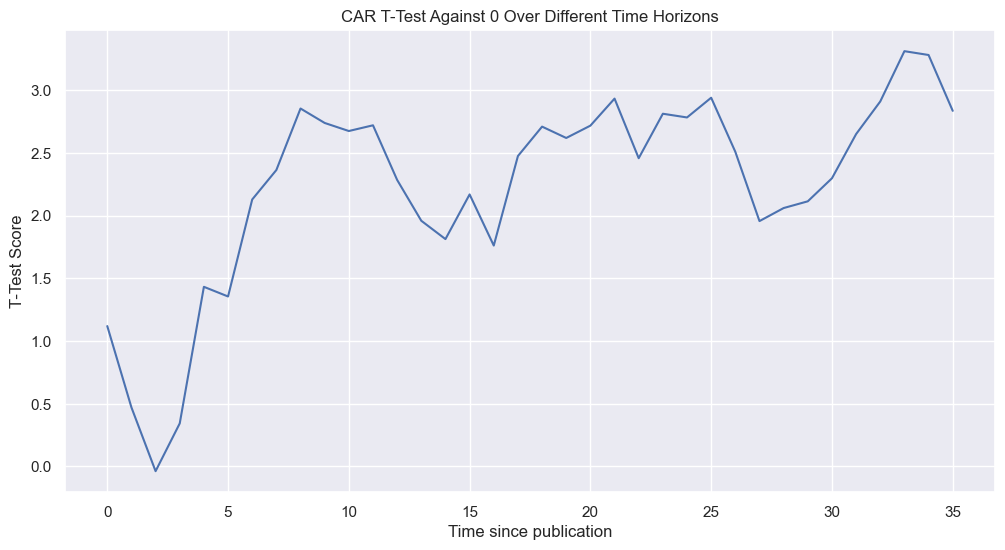

In [17]:
ax, fig = plt.subplots(figsize=(12,6))
_ = plt.plot(t_stat_df.index, t_stat_df['t'])
_ = plt.xlabel("Time since publication")
_ = plt.ylabel("T-Test Score")
_ = plt.title("CAR T-Test Against 0 Over Different Time Horizons")

From the above plot we can see that the results of our t-test seems to show slightly more significance at longer time periods, showing that there are potentially larger returns around 10-days out from the publication of a paper. This could very well be a general trend do to market conditions though, so we should test this over several windows with no publications and see if we get a similar test result. Before we move to that, though, lets quickly look at the p-values for each of these t-tests:

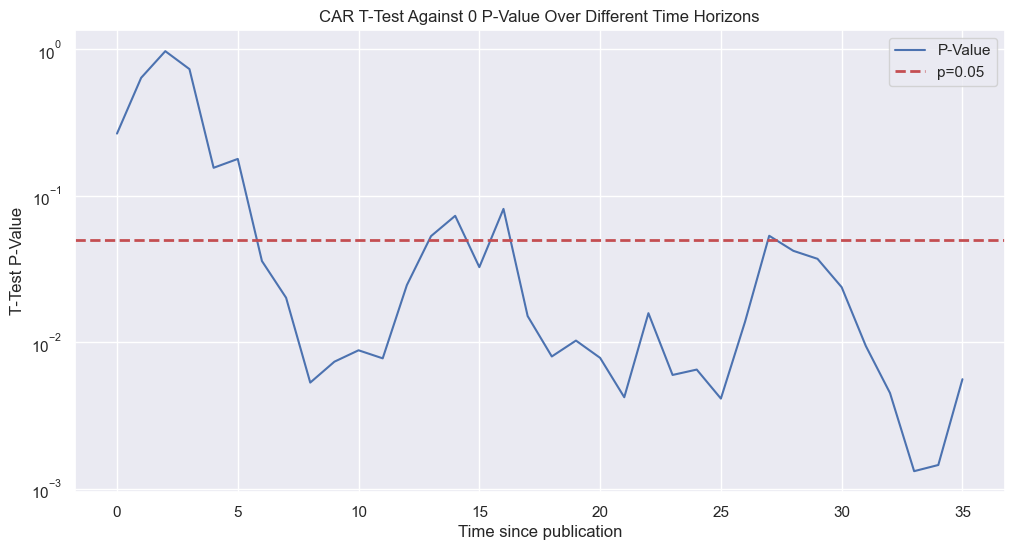

In [47]:
ax, fig = plt.subplots(figsize=(12,6))
_ = plt.semilogy(t_stat_df.index, t_stat_df['p-value'], label='P-Value')
_ = plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='p=0.05')
_ = plt.xlabel("Time since publication")
_ = plt.ylabel("T-Test P-Value")
_ = plt.title("CAR T-Test Against 0 P-Value Over Different Time Horizons")
_ = plt.legend()